# Bitcoin Halving-Strategie: Vergleich von Investitionsstrategien
Dieses Programm analysiert die Bitcoin-Preisentwicklung im Kontext von Halving-Events. Es vergleicht die Wachstumsraten einer "Buy-and-Hold"-Strategie mit einer auf 500-Tage-Zyklen um Halving-Daten basierten Strategie. Zusätzlich werden die Daten visualisiert.


# 1. Importieren von Bibliotheken und Festlegen der Parameter
Dieser Abschnitt importiert alle erforderlichen Bibliotheken und definiert die Halving-Daten sowie den Analysezeitraum.


In [11]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import LogFormatter

# Halving dates
halving_dates = [
    datetime(2016, 7, 9),
    datetime(2020, 5, 11),
    datetime(2024, 4, 21)  # Predicted future date
]

# Constants
start_date = datetime(2010, 1, 1)
end_date = datetime.now() - timedelta(days=3)

# 2. Abrufen und Vorverarbeiten der Bitcoin-Daten
Hier werden die Bitcoin-Daten über yFinance heruntergeladen, die Zeitreihenindizes in Datetime-Objekte konvertiert und wichtige Variablen initialisiert.


In [12]:
# Fetch BTC data from yfinance
btc_data = yf.download("BTC-USD", start=start_date, end=end_date)

# Convert index to datetime
btc_data.index = pd.to_datetime(btc_data.index)

# Initialize variables
final_results = pd.Series(dtype=float)
current_multiplier = 1  # Start with the initial investment multiplier

# Determine the start of the first 1000-day period
first_1000_start = max(start_date, halving_dates[0] - timedelta(days=500))

# Filter BTC data from the first 1000-day start
buy_and_hold_data = btc_data[btc_data.index >= first_1000_start]

# Get the price of Bitcoin at the start of the first 1000-day cycle
buy_and_hold_start_price = buy_and_hold_data.iloc[0]['Close']

# Calculate the "Buy-and-Hold" growth (from the first 1000-day start)
buy_and_hold_growth = buy_and_hold_data['Close'] / buy_and_hold_start_price

# Calculate the "Buy-and-Hold" growth from the start of the dataset
dataset_start_price = btc_data.iloc[0]['Close']
buy_and_hold_from_start = btc_data['Close'] / dataset_start_price

[*********************100%***********************]  1 of 1 completed


# 3. Berechnung der Investitionsstrategien
In diesem Abschnitt werden die Bitcoin-Preisdaten um jedes Halving-Datum analysiert, und die Wachstumsrate der jeweiligen Investitionsstrategie wird berechnet.

In [13]:
# Loop through halving dates
highlight_ranges = []  # To store ranges for highlighting
for halving_date in halving_dates:
    date_before = max(start_date, halving_date - timedelta(days=500))
    date_after = halving_date + timedelta(days=500)  # Extend 500 days after halving
    
    # Filter data for the specific range
    data_in_range = btc_data[(btc_data.index >= date_before) & (btc_data.index <= date_after)]
    
    if data_in_range.empty:
        continue  # Skip if no data available for the range

    # Price at the start of the range (500 days before)
    price_before = data_in_range.iloc[0]['Close']
    
    # Calculate the X-multiplication for each day in this cycle
    daily_changes = (data_in_range['Close'] / price_before) * current_multiplier
    
    # Append to final results only if daily_changes is not empty
    if not daily_changes.empty and not final_results.empty:
        final_results = pd.concat([final_results, daily_changes])
    elif not daily_changes.empty:
        final_results = daily_changes  # Direkt zuweisen, wenn final_results leer ist
    
    # Update the multiplier for the next cycle
    current_multiplier = daily_changes.iloc[-1]  # Last value of this cycle

    # Add the range for highlighting
    highlight_ranges.append((date_before, date_after))

# 4. Aufbereitung der Ergebnisse für die Visualisierung
Die Daten werden hier für die Darstellung vorbereitet. Lücken werden durch Vorwärtsauffüllung (`forward fill`) geschlossen.

In [14]:
# Extend x-axis to 700 days after the last halving
final_x_end = halving_dates[-1] + timedelta(days=700)
full_index = pd.date_range(start=final_results.index[0], end=final_x_end, freq='D')

# Reindex and fill missing values forward only between real data
final_results = final_results.reindex(full_index).ffill()

# Mask values after the current end date
final_results.loc[final_results.index > end_date] = None

# 5. Visualisierung der Strategien und Vergleich
Dieser Abschnitt visualisiert die Ergebnisse der Halving-Strategie und der "Buy-and-Hold"-Strategien im Vergleich. Es werden auch wichtige Ereignisse wie Halving-Daten hervorgehoben.

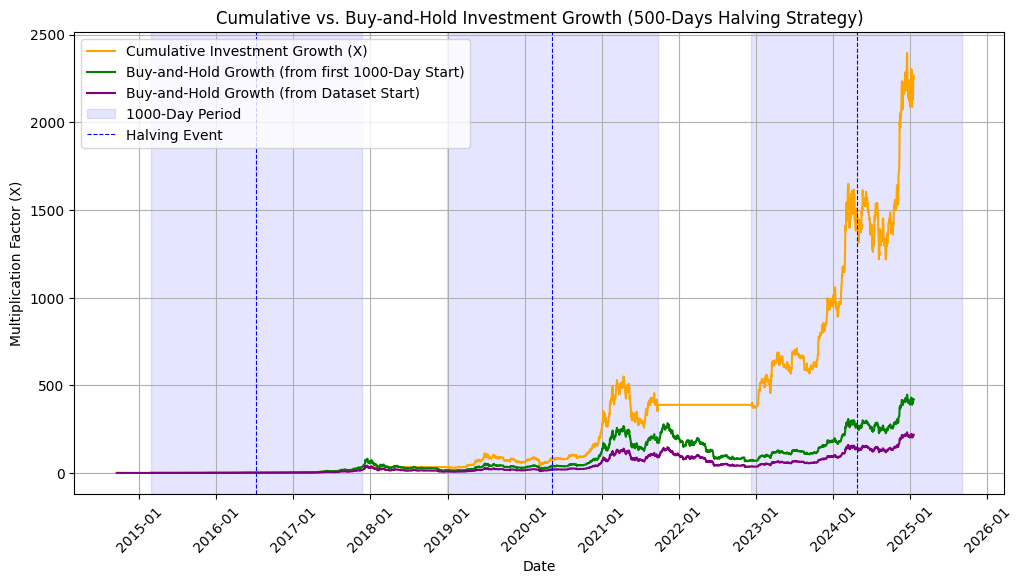

In [15]:
# Plot the results
plt.figure(figsize=(12, 6))

# Plot cumulative growth line
lines = plt.plot(final_results.index, final_results, color='orange', label='Cumulative Investment Growth (X)')
line1 = lines[0]  # Das erste Linienobjekt auswählen

# Plot "Buy-and-Hold" growth (from the first 1000-day start)
lines = plt.plot(buy_and_hold_growth.index, buy_and_hold_growth, color='green', label='Buy-and-Hold Growth (from first 1000-Day Start)')
line2 = lines[0]  # Das erste Linienobjekt auswählen

# Plot "Buy-and-Hold" growth (from the start of the dataset)
lines = plt.plot(buy_and_hold_from_start.index, buy_and_hold_from_start, color='purple', label='Buy-and-Hold Growth (from Dataset Start)')
line3 = lines[0]  # Das erste Linienobjekt auswählen

# Highlight 1000-day periods with a light blue background
for start, end in highlight_ranges:
    # Ensure the last range extends to 700 days after the final halving
    end = min(end, final_x_end)
    plt.axvspan(start, end, color='blue', alpha=0.1, label='1000-Day Period')

# Add Halving markers
halving_lines = []
for halving_date in halving_dates:
    line = plt.axvline(halving_date, color='blue', linestyle='--', linewidth=0.8, label='Halving Event')
    halving_lines.append(line)

# Format x-axis for dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)

# Legende explizit erstellen
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))  # Create a dictionary to remove duplicates
plt.legend(unique.values(), unique.keys(), loc='upper left')

# Set titles and labels
plt.title('Cumulative vs. Buy-and-Hold Investment Growth (500-Days Halving Strategy)')
plt.xlabel('Date')
plt.ylabel('Multiplication Factor (X)')
plt.grid()
plt.show()

# 6. Logarithmische Visualisierung der Ergebnisse
In diesem Abschnitt wird der Graph aus den vorherigen Berechnungen mit einer logarithmischen Skala für die Y-Achse dargestellt. Diese Darstellung ist besonders hilfreich, um exponentielle Unterschiede hervorzuheben.

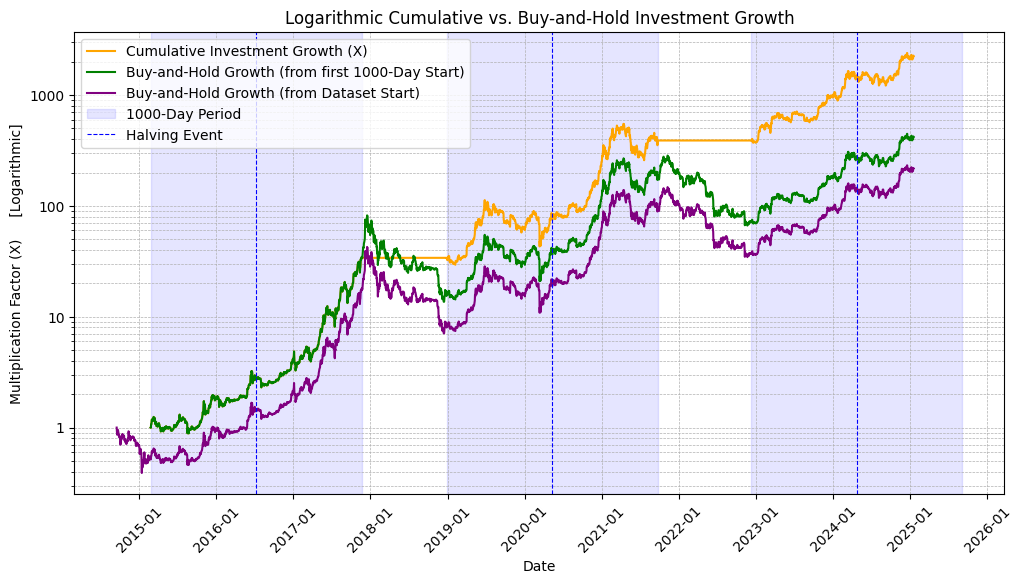

In [16]:
# Logarithmic Visualization
plt.figure(figsize=(12, 6))

# Plot cumulative growth line
plt.plot(final_results.index, final_results, color='orange', label='Cumulative Investment Growth (X)')

# Plot "Buy-and-Hold" growth (from the first 1000-day start)
plt.plot(buy_and_hold_growth.index, buy_and_hold_growth, color='green', label='Buy-and-Hold Growth (from first 1000-Day Start)')

# Plot "Buy-and-Hold" growth (from the start of the dataset)
plt.plot(buy_and_hold_from_start.index, buy_and_hold_from_start, color='purple', label='Buy-and-Hold Growth (from Dataset Start)')

# Highlight 1000-day periods with a light blue background
for start, end in highlight_ranges:
    end = min(end, final_x_end)  # Ensure the last range extends correctly
    plt.axvspan(start, end, color='blue', alpha=0.1, label='1000-Day Period')

# Add Halving markers
for halving_date in halving_dates:
    plt.axvline(halving_date, color='blue', linestyle='--', linewidth=0.8, label='Halving Event')

# Format x-axis for dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)

# Set Y-axis to logarithmic scale and apply custom formatting
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(LogFormatter(base=10, labelOnlyBase=False))

# Legend
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))  # Remove duplicate entries
plt.legend(unique.values(), unique.keys(), loc='upper left')

# Titles and labels
plt.title('Logarithmic Cumulative vs. Buy-and-Hold Investment Growth')
plt.xlabel('Date')
plt.ylabel('Multiplication Factor (X)     [Logarithmic]')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()